# Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

## Load the Dataset

In [2]:
df = pd.read_excel("Online Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.shape

(541909, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [6]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

# Data Preprocessing

In [7]:
# Checking for missing values
df = df.dropna()

In [8]:
df.shape

(406829, 8)

In [9]:
# Remove rows with negative or zero quantity and unit price
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Create a new feature for total spending
df['TotalSpending'] = df['Quantity'] * df['UnitPrice']

In [10]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (pd.to_datetime('today') - pd.to_datetime(x.max())).days,  # Recency
    'InvoiceNo': 'count',  # Frequency
    'TotalSpending': 'sum'  # Monetary Value
}).reset_index()

# Rename columns for clarity
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm

,CustomerID,Recency,Frequency,Monetary
0,12346.0,5070,1,77183.60
1,12347.0,4747,182,4310.00
2,12348.0,4820,31,1797.24
3,12349.0,4763,73,1757.55
4,12350.0,5055,17,334.40
...,...,...,...,...
4333,18280.0,5022,10,180.60
4334,18281.0,4925,7,80.82
4335,18282.0,4752,12,178.05
4336,18283.0,4748,756,2094.88


In [11]:
rfm['Monetary'] = np.log1p(rfm['Monetary'])

# Scale the features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

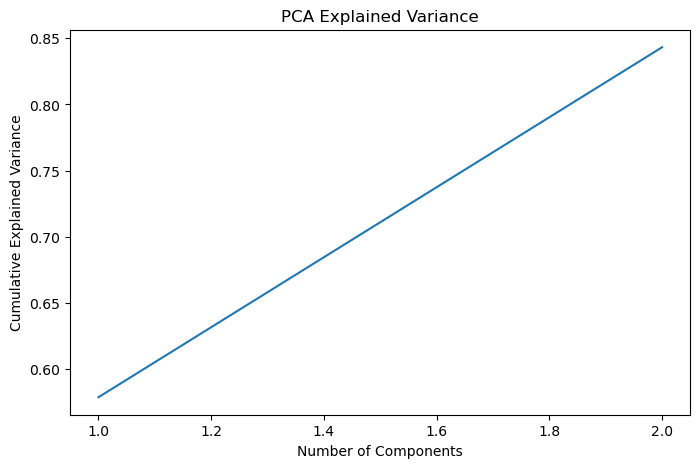

In [12]:
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

# Visualize explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.show()

c:\Users\Ahmed\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Ahmed\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Ahmed\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Ahmed\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

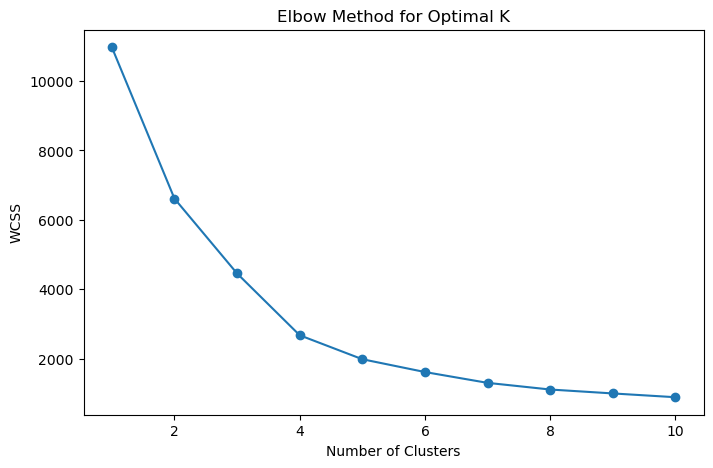

In [13]:
# Using Elbow Method
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_pca)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.show()

c:\Users\Ahmed\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Ahmed\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Ahmed\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Ahmed\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

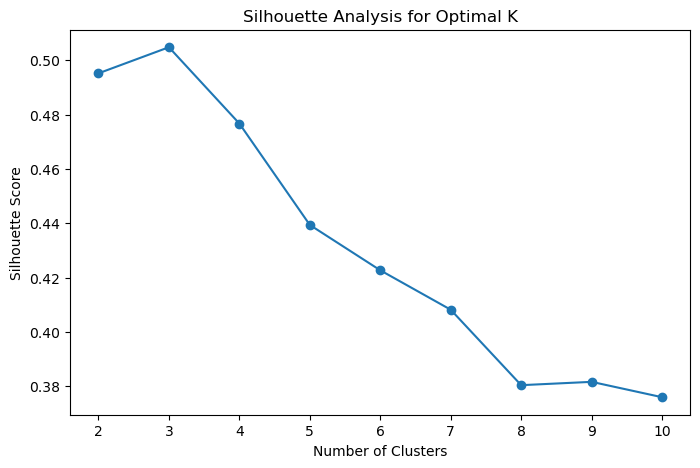

In [14]:
# Using Silhouette Score
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_pca)
    score = silhouette_score(rfm_pca, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal K')
plt.show()

# Optimal clusters determined from above (e.g., 4 clusters)
optimal_k = 4

In [15]:
#  K-means Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_pca)


c:\Users\Ahmed\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [16]:
# Analyze clusters
cluster_profiles = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

print("Cluster Profiles:")
print(cluster_profiles)

Cluster Profiles:
   Cluster      Recency    Frequency   Monetary
0        0  4797.466102    48.183475   6.371644
1        1  4992.303502    23.311284   5.547108
2        2  4746.500000  5807.000000  11.002016
3        3  4767.472516   250.506342   8.266005


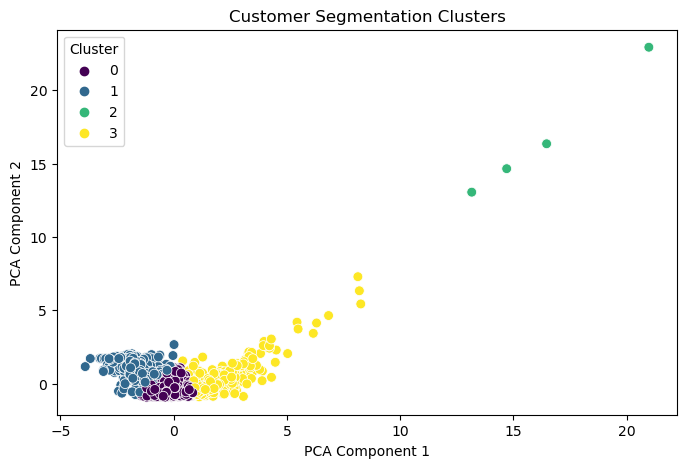

In [17]:
# Step 9: Visualization of Clusters
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x=rfm_pca[:, 0],
    y=rfm_pca[:, 1],
    hue=rfm['Cluster'],
    palette='viridis',
    s=50
)
plt.title('Customer Segmentation Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


In [18]:
# Step 10: Recommendations
# Example: Personalized marketing strategies for each cluster
for cluster in cluster_profiles['Cluster']:
    print(f"Cluster {cluster} - Recency: {cluster_profiles.loc[cluster, 'Recency']}, "
          f"Frequency: {cluster_profiles.loc[cluster, 'Frequency']}, "
          f"Monetary: {cluster_profiles.loc[cluster, 'Monetary']}")

Cluster 0 - Recency: 4797.466101694915, Frequency: 48.18347457627119, Monetary: 6.371643617422419
Cluster 1 - Recency: 4992.303501945526, Frequency: 23.311284046692606, Monetary: 5.547107509104674
Cluster 2 - Recency: 4746.5, Frequency: 5807.0, Monetary: 11.002016004810551
Cluster 3 - Recency: 4767.472515856237, Frequency: 250.5063424947146, Monetary: 8.266005302525647
